In [1]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pylab as plt
from datetime import datetime
from dateutil.parser import parse
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# utility functions used

In [2]:
HOSTNAME_FIELD = 'Hostname'
DATA_PATH = '/opt/notebooks/datasets/NB_GA_Data_1.xlsx'

def pull_raw_data(file_location):
    raw = pd.read_excel(file_location, None)
    return raw

def get_region_data(region, file_location):
    """
    Function for fetching region data
    :file_location: file path for data source
    :region:
        NB GA Data 1:
            NB | GA | US Data
            NB | GA | CA Data
            NB | GA | AU Data
            NB | GA | NZ Data
            NB | GA | JNBO Data
        NB GA Data 2:
            NB | GA | EU + UK
            NB | GA | TW
            NB | GA | HK
            NB | GA | MY
            NB | GA | SG
    """
    all_data = pull_raw_data(file_location)
    region_data = all_data[region]
    region_data = region_data.copy(deep=False)
    region_data['Date'] = pd.to_datetime(region_data['Date'])
    region_data.set_index('Date', inplace=True)
    region_data.index = pd.DatetimeIndex(region_data.index.values, freq=region_data.index.inferred_freq)
    asc = region_data.sort_index()
    return asc

def get_hostname_data(hostname, region_data):
    hostname_data = region_data[region_data[HOSTNAME_FIELD] == hostname]
    return hostname_data

def apply_index_freq(data, freq):
    return data.asfreq(freq)

def aggregate_daily_data(data):
    data = data.copy(deep=False)
    data.loc[:, 'Year'] = data.index.year
    data.loc[:, 'Month'] = data.index.month
    data.loc[:, 'Day'] = 1
    data.loc[:, 'Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
    return data.groupby('Date').agg({'Sessions':'sum', 'Pageviews':'sum'})

def filter_by_date(data, left_datetime=None, right_datetime=None):
    """
    Function for filtering data not recorded by a complete month
    :left_datetime: filter data whose date is less than left_datetime
    :right_datetime: filter data whose date is greater than right_datetime
    """
    if left_datetime:
        data = data[data.index > left_datetime]
    
    if right_datetime:
        data = data[data.index < right_datetime]
    
    return data

# exponential smoothing

In [3]:
def exp_smoothing(raw_series, alpha=0.05):
    """
    Function for fitting an exponential smoothing trend to time series data
    :param raw_series: a numpy date indexed series with no missing date values
    :param alpha: (default 0.05) the smoothing factor (range 0:1) to define the weighting 
    of prior values to current value's point (lower is smoother)
    """
    output = [raw_series[0]]
    for i in range(1, len(raw_series)):
        output.append(raw_series[i] * alpha + (1-alpha) * output[i-1])
    return output

# metric and error estimation

## mae

In [4]:
def calculate_mae(raw_series, smoothed_series, window, scale):
    """
    Function for calculating mae through scikit-learn and build stddev error series
    :param raw_series: the raw data series, date indexed
    :param smoothed_series: the exponentially smoothed series with identical index to raw_series
    :param window: the size of the smoothing window
    :param scale: percentile value of the standard normal distribution expressed in terms of stddev value
    """
    # dictionary to store the resulting values of the function's logic
    res = {}
    
    mae_value = mean_absolute_error(raw_series[window:], smoothed_series[window:])
    
    # store the mae value in the dictionary
    res['mae'] = mae_value
    
    # calculate the stddev between the raw data and the smoothed data, filtering out the incomplete lagged
    # exponential smoothing data
    # the elements of the smoothed series that couldn't calculate based on an incomplete window will be null)
    deviation = np.std(raw_series[window:] - smoothed_series[window:])
    
    # store the stddev data in the dictionary
    res['stddev'] = deviation
    
    # calculate the scaled stddev (e.g. with a scale of '2', we're calculating 2-sigma around the smoothed value)
    yhat = mae_value + scale * deviation
    
    # store the offset values of stddev as two separate series for plotting
    res['yhat_low'] = smoothed_series - yhat
    res['yhat_high'] = smoothed_series + yhat
    return res

## mape

In [5]:
def mape(y_true, y_pred):
    """ 
    Function for calculating mean absolute percentage error 
    (for comparing models of different series magnitudes to one another for objective quality comparison)
    :param y_true: the 'validation' series (a.k.a. 'test')
    :param y_pred: the forecast series (a.k.a. the result of a '.predict()' method call)
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## encapsulate all error calculations in one function

In [6]:
def calculate_errors(y_true, y_pred):
    """ 
    Function to calculate the 'core' forecasting error metrics for a regression problem.
    :param y_true: the test series (ground truth holdout data)
    :param y_pred: the forecast (predicted) series
    """
    # create a dictionary to store all of the metrics
    error_scores = {}
    
    # define a variable for mse
    # it's also going to be used to calculate the rmse value
    mse = mean_squared_error(y_true, y_pred)
    
    # store all of the metrics into the dictionary for ease of access later. 
    #  (don't return tuples - it's a bad practice because it's really hard for other humans to read)
    error_scores['mae'] = mean_absolute_error(y_true, y_pred)
    error_scores['mape'] = mape(y_true, y_pred)
    error_scores['mse'] = mse
    error_scores['rmse'] = sqrt(mse)
    error_scores['explained_var'] = explained_variance_score(y_true, y_pred)
    error_scores['r2'] = r2_score(y_true, y_pred)
    return error_scores

# smoothing plots

In [7]:
def smoothed_time_plots(time_series, time_series_name, image_name, smoothing_window, exp_alpha=0.05, 
                        yhat_scale=1.96, style='seaborn-v0_8', plot_size=(16, 24)):
    """ Function for generating the reference exponential smoothing plot for reference
    :param time_series: the date indexed time series 
    :param time_series_name: name of the time series (for plot labeling)
    :param image_name: name of the file to save the image as in .svg format
    :param smoothing_window: the size of the smoothing window to lag over for exponential smoothing (a bigger window
      results in a lower rate of change over time)
    :param exp_alpha: smoothing factor (scale 0:1) to define weighting of prior window values on the curve 
        (higher is less smooth, taking more weight for more recent values in the window)
    :param yhat_scale: (default 1.96, representing 97.5% of the standard normal distribution) 
        factor corresponding to the percentile value fo the standard normal distribution expressed in terms of stddev
    :param style: matplotlib.pyplot style type for the plots. defaulted as seaborn style.
    :param plot_size: the size of the entire figure being generated in inches.
    """
    # currying dictionary to store the resulting data
    reference_collection = {}
    # conversion of the series into a pandas Series type
    ts = pd.Series(time_series)
    # shorthand way of defining an encapsulating formatting type for all pyplot elements within the definition
    with plt.style.context(style=style):
        # create references to the overall figure element and each of the subplots within the figure (axes)
        fig, axes = plt.subplots(3, 1, figsize=plot_size)  
        
        # cleanup of the plots to allow some spacing for titles / labels
        plt.subplots_adjust(hspace=0.3)
        
        # create the series for rolling moving average over a specified window (the most basic approach)
        moving_avg = ts.rolling(window=smoothing_window).mean()
        
        # create the exponentially smoothed average series
        exp_smoothed = exp_smoothing(ts, exp_alpha)
        
        # calculate the mae and the error estimations for the moving average using the code from listing 6.2
        res = calculate_mae(time_series, moving_avg, smoothing_window, yhat_scale)
        
        # calculate the mae and error estimations for the exponentially smoothed data
        res_exp = calculate_mae(time_series, exp_smoothed, smoothing_window, yhat_scale)
        
        # create a standard Pandas Series from the exponentially smoothed data
        exp_data = pd.Series(exp_smoothed, index=time_series.index)
        
        # create Pandas Series for the stddev error trends
        exp_yhat_low_data = pd.Series(res_exp['yhat_low'], index=time_series.index)
        exp_yhat_high_data = pd.Series(res_exp['yhat_high'], index=time_series.index)
        
        # Plot the raw data
        axes[0].plot(ts, '-', label=f'Trend for {time_series_name}')
        axes[0].legend(loc='upper left')
        axes[0].set_title(f'Raw Data trend for {time_series_name}')
        
        # plot the moving average data
        axes[1].plot(ts, '-', label=f'Trend for {time_series_name}')
        axes[1].plot(moving_avg, 'g-', label=f'Moving Average with window: {smoothing_window}')
        axes[1].plot(res['yhat_high'], 'r--', label='yhat bounds')
        axes[1].plot(res['yhat_low'], 'r--')
        axes[1].set_title(f"Moving Average Trend for window: {smoothing_window} with MAE of: {res['mae']:.1f}")
        axes[1].legend(loc='upper left')
        
        # plot the exponentially smoothed data
        axes[2].plot(ts, '-', label=f'Trend for {time_series_name}')
        axes[2].legend(loc='upper left')
        axes[2].plot(exp_data, 'g-', label=f'Exponential Smoothing with alpha: {exp_alpha}')
        axes[2].plot(exp_yhat_high_data, 'r--', label='yhat bounds')
        axes[2].plot(exp_yhat_low_data, 'r--')
        axes[2].set_title(f"Exponential Smoothing Trend for alpha: {exp_alpha} with MAE of: {res_exp['mae']:.1f}")
        axes[2].legend(loc='upper left')
        
        # save it for reference
        plt.savefig(image_name, format='svg')
        
        # clean up the display to 'make it pretty'
        plt.tight_layout()
        
        # record these plots and the series that were calculated from the data in the dictionary
        reference_collection['plots'] = fig
        reference_collection['moving_average'] = moving_avg
        reference_collection['exp_smooth'] = exp_smoothed
        
        # return the dictionary that we've put the data into
        return reference_collection

In [8]:
def plot_predictions(y_true, y_pred, time_series_name, value_name, image_name, style='seaborn-v0_8', plot_size=(16, 12)):
    """ Function for a standardized forecasting visualization
    :param y_true: the ground-truth values during the forecasting period
    :param y_pred: the forecast values during the holdout period
    :param time_series_name: a name for the plot
    :param value_name: the name for our y-axis on the plot
    :param image_name: the name of the file to save the visualization as in svg format
    :param style: (default 'seaborn') the visual style of the plots
    :param plot_size: (default 16 x 12 inches) the size of the figure we're going to generate
    """
    # dictionary for currying
    validation_output = {} 
    
    # full error metrics suite as shown in listing 6.6
    error_values = calculate_errors(y_true, y_pred)
    
    # store all of the raw values of the errors
    validation_output['errors'] = error_values
    
    # create a string to populate a bounding box with on the graph
    text_str = '\n'.join((
        'mae = {:.3f}'.format(error_values['mae']),
        'mape = {:.3f}'.format(error_values['mape']),
        'mse = {:.3f}'.format(error_values['mse']),
        'rmse = {:.3f}'.format(error_values['rmse']),
        'explained var = {:.3f}'.format(error_values['explained_var']),
        'r squared = {:.3f}'.format(error_values['r2']),
    )) 
    with plt.style.context(style=style):
        fig, axes = plt.subplots(1, 1, figsize=plot_size)
        axes.plot(y_true, 'b-', label='Test data for {}'.format(time_series_name))
        axes.plot(y_pred, 'r-', label='Forecast data for {}'.format(time_series_name))
        axes.legend(loc='upper left')
        axes.set_title('Raw and Predicted data trend for {}'.format(time_series_name))
        axes.set_ylabel(value_name)
        axes.set_xlabel(y_true.index.name)

         # create an overlay bounding box so that all of our metrics are displayed on the plot
        props = dict(boxstyle='round', facecolor='oldlace', alpha=0.5)
        axes.text(0.05, 0.9, text_str, transform=axes.transAxes, fontsize=12, verticalalignment='top', bbox=props)
        validation_output['plot'] = fig
        plt.savefig(image_name, format='svg')
        plt.tight_layout()
    return validation_output

# Time split

In [9]:
def split_correctness(data, train, test):
    """
    Utility function for making sure that the split that we conducted split the data correctly
    :param data: the full data set
    :param train: the train portion of the data set
    :param test: the test portion of the data set
    """
    assert data.size == train.size + test.size, \
    "Train count {} and test count {} did not match to source count {}".format(train.size, test.size, data.size)

# parse: https://dateutil.readthedocs.io/en/stable/parser.html
def generate_splits(data, date):
    """
    Function for splitting raw data between train and test at a boundary point
    that is specified as a parse-able date format.
    :param data: the raw data
    :param date: a date, in a format that 'can be parsed' to serve as the boundary point
    """
    parsed_date = parse(date, fuzzy=True)
    nearest_date = data[:parsed_date].iloc(0)[-1].name
    train = data[:nearest_date]
    test = data[nearest_date:][1:]
    split_correctness(data, train, test)
    return train, test

## data ingestion

In [10]:
DATA_PATH = '/opt/notebooks/datasets/NB_GA_Data_1.xlsx'

newbalancecom = get_hostname_data('www.newbalance.com', 
                                  region_data = get_region_data('NB | GA | US Data', DATA_PATH))

newbalancecom_month = apply_index_freq(aggregate_daily_data(newbalancecom), 'MS')
newbalancecom_month = filter_by_date(newbalancecom_month, left_datetime=datetime(2016, 11, 30))

## train, test split

In [12]:
train, test = generate_splits(newbalancecom_month, '2021-12-01')

## var model
- usage example from api doc: https://www.statsmodels.org/dev/vector_ar.html

In [27]:
var_model = VAR(train[['Sessions', 'Pageviews']])
var_model.select_order(12)
var_fit = var_model.fit()
lag_order = var_fit.k_ar
var_pred = var_fit.forecast(test[['Sessions', 'Pageviews']].values[-lag_order:], 
                            test.index.size)

# To plot all of this, we'll need to extract the predictions from the forecast data. Geez this seems complex...
var_pred_session = pd.Series(np.asarray(list(zip(*var_pred))[0], dtype=np.float32), index=test.index)
var_pred_pageview = pd.Series(np.asarray(list(zip(*var_pred))[1], dtype=np.float32), index=test.index)

# Let's use our plot_predictions() function to see how we did!
var_prediction_score = plot_predictions(test['Sessions'], 
                                        var_pred_session, 
                                        "VAR model Sessions newbalance.com", 
                                        "Sessions", 
                                        "var_newbalancecom_sessions.svg")

var_prediction_score_intl = plot_predictions(test['Pageviews'], 
                                        var_pred_pageview, 
                                        "VAR model Pageviews newbalance.com", 
                                        "Pageviews", 
                                        "var_newbalancecom_pageview.svg")

In [14]:
var_model = VAR(train[['Sessions', 'Pageviews']])
var_model.select_order(12)
var_fit = var_model.fit(12)
lag_order = var_fit.k_ar
var_pred = var_fit.forecast(test[['Sessions', 'Pageviews']].values[-lag_order:], 
                            test.index.size)

# To plot all of this, we'll need to extract the predictions from the forecast data. Geez this seems complex...
var_pred_session = pd.Series(np.asarray(list(zip(*var_pred))[0], dtype=np.float32), index=test.index)
var_pred_pageview = pd.Series(np.asarray(list(zip(*var_pred))[1], dtype=np.float32), index=test.index)

# Let's use our plot_predictions() function to see how we did!
var_prediction_score = plot_predictions(test['Sessions'], 
                                        var_pred_session, 
                                        "VAR model Sessions newbalance.com", 
                                        "Sessions", 
                                        "var_newbalancecom_sessions_lag12.svg")

var_prediction_score_intl = plot_predictions(test['Pageviews'], 
                                        var_pred_pageview, 
                                        "VAR model Pageviews newbalance.com", 
                                        "Pageviews", 
                                        "var_newbalancecom_pageview_lag12.svg")

/tmp/ipykernel_2153/1759953441.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  var_pred_session_expanded = np.exp(var_pred_session.cumsum()) * test['Sessions'][0]
/tmp/ipykernel_2153/1759953441.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  var_pred_pageview_expanded = np.exp(var_pred_pageview.cumsum()) * test['Pageviews'][0]


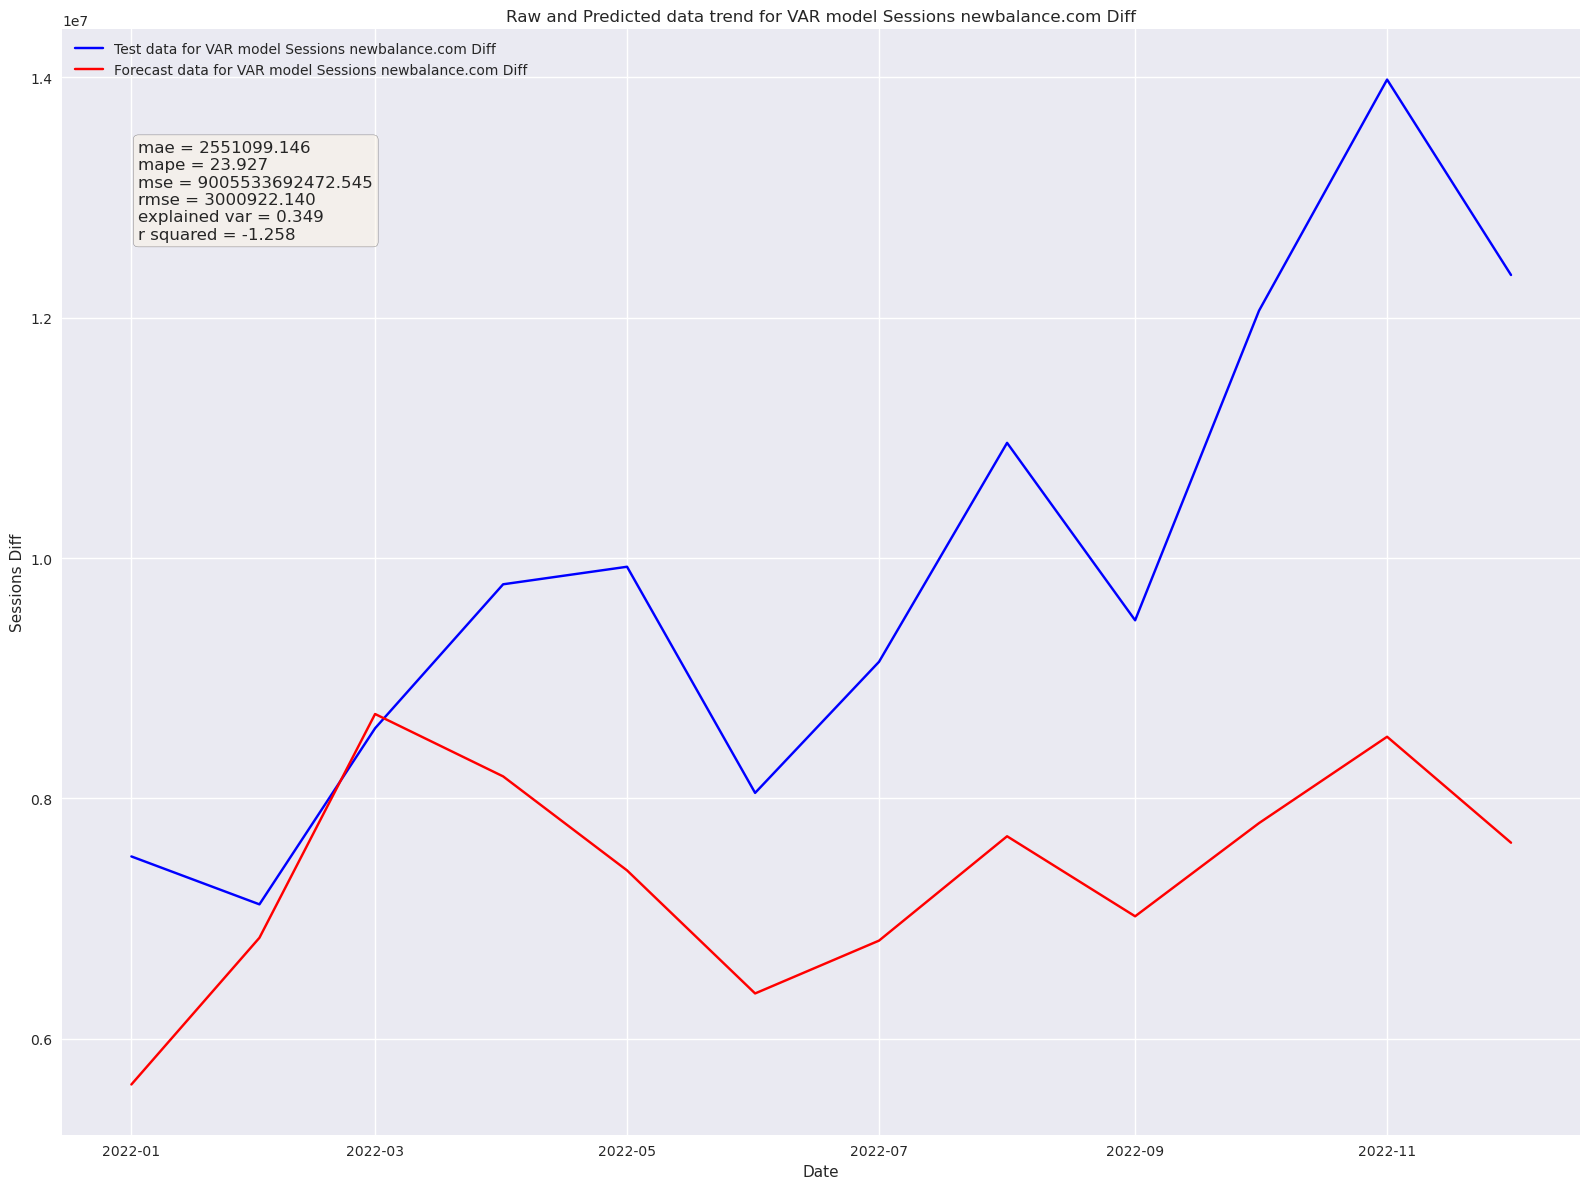

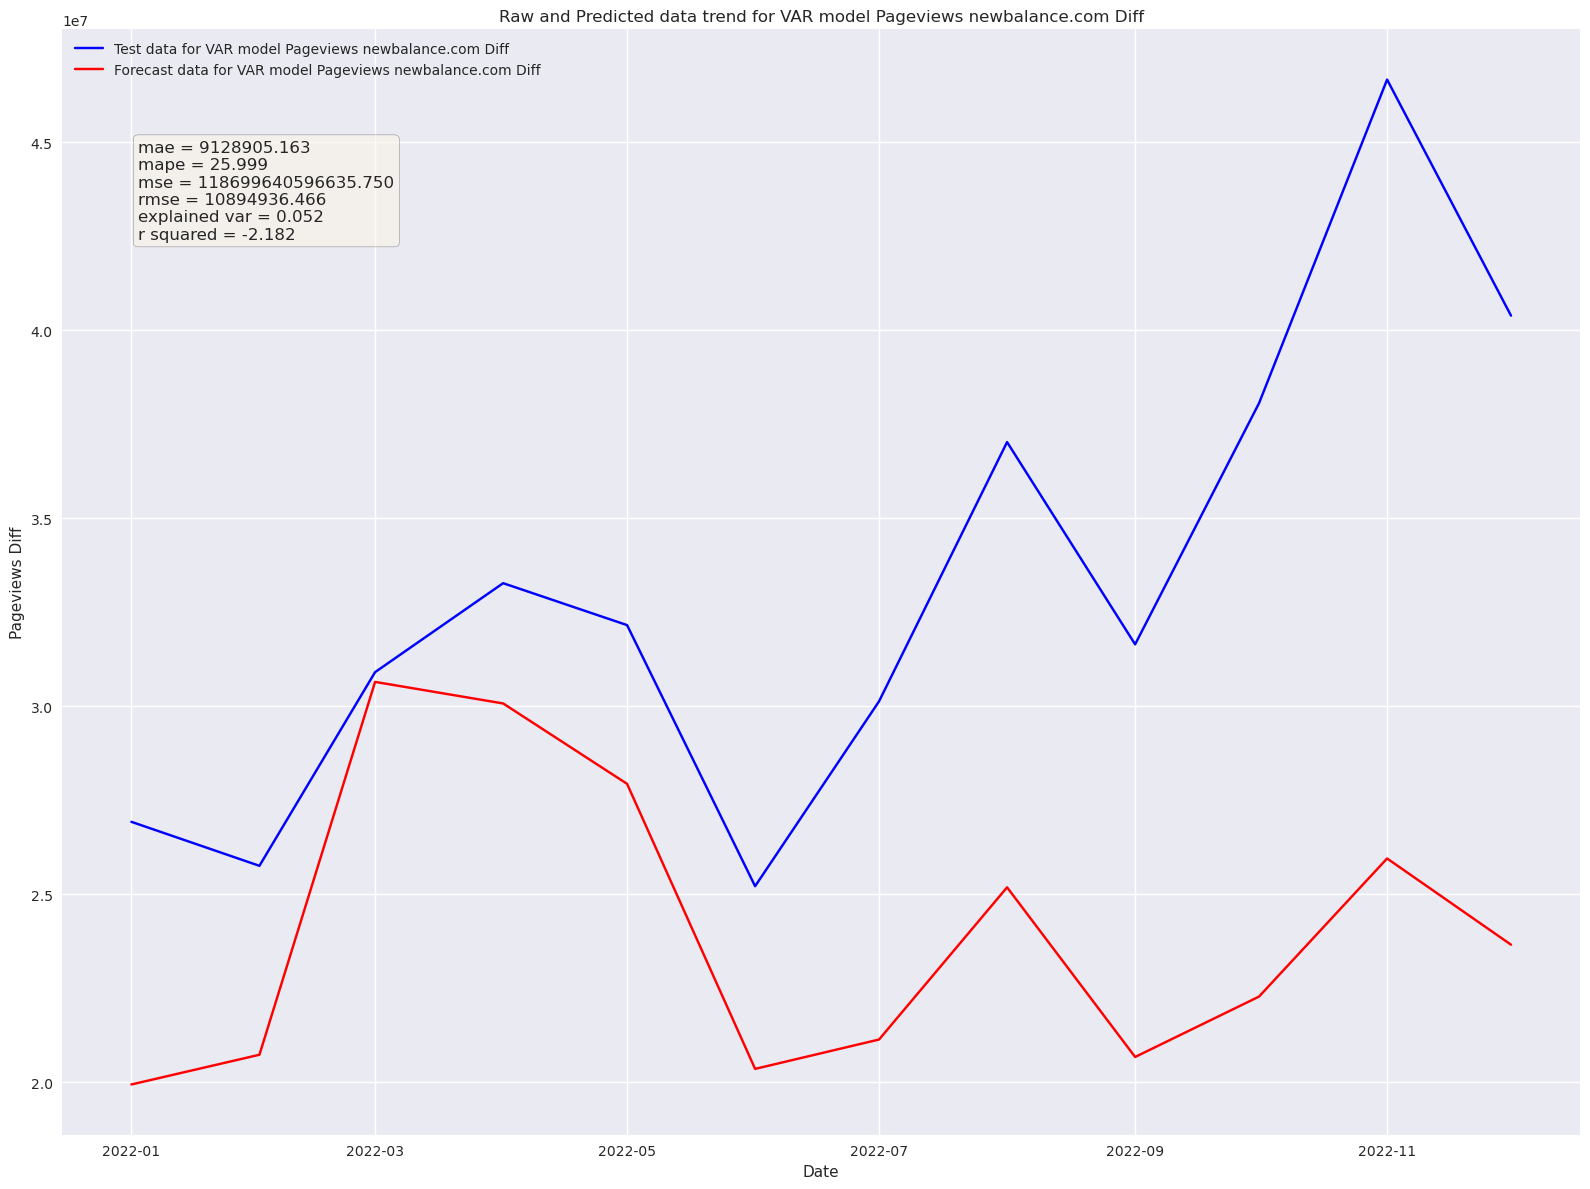

In [13]:
# Let's take the log of the series, then do a basic differencing function on the data
newbalancecom_month['Sessions Diff'] = np.log(newbalancecom_month['Sessions']).diff()
newbalancecom_month['Pageviews Diff'] = np.log(newbalancecom_month['Pageviews']).diff()

# since we're differencing, we need to drop the leading value from the series as it is null.
newbalancecom_month = newbalancecom_month.dropna()
train, test = generate_splits(newbalancecom_month, '2021-12-01')

var_model = VAR(train[['Sessions Diff', 'Pageviews Diff']])
var_model.select_order(12)
var_fit = var_model.fit(12)
lag_order = var_fit.k_ar
var_pred = var_fit.forecast(test[['Sessions Diff', 'Pageviews Diff']].values[-lag_order:], 
                            test.index.size)
var_pred_session = pd.Series(np.asarray(list(zip(*var_pred))[0], dtype=np.float32), index=test.index)
var_pred_pageview = pd.Series(np.asarray(list(zip(*var_pred))[1], dtype=np.float32), index=test.index)

# After modeling is complete and the forecast is generated, we need to remove the differencing aspect and then 
# invert the log values to get back to the original numeric space.
var_pred_session_expanded = np.exp(var_pred_session.cumsum()) * test['Sessions'][0]
var_pred_pageview_expanded = np.exp(var_pred_pageview.cumsum()) * test['Pageviews'][0]

# Let's use our plot_predictions() function to see how we did!
var_prediction_score = plot_predictions(test['Sessions'], 
                                        var_pred_session_expanded, 
                                        "VAR model Sessions newbalance.com Diff", 
                                        "Sessions Diff", 
                                        "var_newbalancecom_sessions_lag12_diff.svg")

var_prediction_score_intl = plot_predictions(test['Pageviews'], 
                                             var_pred_pageview_expanded, 
                                             "VAR model Pageviews newbalance.com Diff", 
                                             "Pageviews Diff", 
                                             "var_newbalancecom_pageview_lag12_diff.svg")


## Linear model: linear regression, RidgeCV, LassoCV, ElasticNetCV, ensemble

In [33]:
# data ingestion
DATA_PATH = '/opt/notebooks/datasets/NB_GA_Data_1.xlsx'
newbalancecom = get_hostname_data('www.newbalance.com', 
                                  region_data = get_region_data('NB | GA | US Data', DATA_PATH))
newbalancecom_month = apply_index_freq(aggregate_daily_data(newbalancecom), 'MS')
newbalancecom_month = filter_by_date(newbalancecom_month, left_datetime=datetime(2016, 11, 30))

In [53]:
# generate features
newbalancecom_month['Year'] = newbalancecom_month.index.year
newbalancecom_month['Month'] = newbalancecom_month.index.month
newbalancecom_month['months_from_start'] = ((newbalancecom_month.index.year - newbalancecom_month.index[0].year) * 12) + (newbalancecom_month.index.month - newbalancecom_month.index[0].month)
newbalancecom_month['years_from_start'] = (newbalancecom_month['Year'] - newbalancecom_month['Year'][0])
newbalancecom_month['thanksgiving'] = (newbalancecom_month['Month'] == 11) * 1

/tmp/ipykernel_638/2457782910.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  newbalancecom_month['years_from_start'] = (newbalancecom_month['Year'] - newbalancecom_month['Year'][0])


In [57]:
# linear regression
X = newbalancecom_month[['months_from_start', 'years_from_start', 'thanksgiving']]
Y = newbalancecom_month[['Sessions']]

date_cutoff = '2021-12-01'
X_train, X_test = generate_splits(X, date_cutoff)
Y_train, Y_test = generate_splits(Y, date_cutoff)
Y_train_arr = Y_train.values.ravel()
Y_test_arr = Y_test.values.ravel()

lr = LinearRegression(
    fit_intercept=False
).fit(X_train, Y_train_arr)

lr_validate = Y_test.copy(deep=False)
lr_validate['prediction'] = lr.predict(X_test)

# ridge regression
ridge = RidgeCV(
    alphas=[0.1, 0.5, 0.7, 0.95, 1.0, 10.0],
    fit_intercept=False,
    gcv_mode='auto' # 'svd', 'eigen'
).fit(X_train, Y_train_arr)

ridge_validate = Y_test.copy(deep=False)
ridge_validate['prediction'] = ridge.predict(X_test)

# lasso regression
lasso = LassoCV(
    eps=1e-3,
    n_alphas=100,
    fit_intercept=False,
    precompute='auto',
    tol=1e-8,
    selection='cyclic', #cyclic
    random_state=42
).fit(X_train, Y_train_arr)

lasso_validate = Y_test.copy(deep=False)
lasso_validate['prediction'] = lasso.predict(X_test)

# elastic net
elastic = ElasticNetCV(
    l1_ratio=[1e-6, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0],
    n_alphas=100,
    fit_intercept=False,
    precompute='auto',
    tol=1e-4,
    positive=False,
    selection='random', #cyclic
    random_state=42
).fit(X_train, Y_train_arr)

elastic_validate = Y_test.copy(deep=False)
elastic_validate['prediction'] = elastic.predict(X_test)

# ensemble
ensemble = Y_test.copy(deep=False)
ensemble['ols'] = lr.predict(X_test)
ensemble['ridge'] = ridge.predict(X_test)
ensemble['lasso'] = lasso.predict(X_test)
ensemble['elastic'] = lasso.predict(X_test)
ensemble['prediction'] = ensemble[['ols', 'ridge', 'lasso', 'elastic']].mean(axis=1)

# Let's see what OLS regression can do for us...
ols_plot = plot_predictions(Y_test['Sessions'], lr_validate['prediction'], 
                 'OLS Regression newbalancecom Sessions','Sessions', 'ols_reg.svg')
# Check ridge regression
ridge_plot = plot_predictions(Y_test['Sessions'], ridge_validate['prediction'], 
                 'Ridge Regression newbalancecom Sessions', 'Sessions', 'ridge.svg')
# and Lasso
lasso_plot = plot_predictions(Y_test['Sessions'], lasso_validate['prediction'], 
                 'Lasso Regression newbalancecom Sessions', 'Sessions', 'lasso.svg')
# and ElasticNet
enet_plot = plot_predictions(Y_test['Sessions'], elastic_validate['prediction'], 
                 'ElasticNet Regression newbalancecom Sessions', 'Sessions', 'enet.svg')
# see what the ensemble looks like
ensemble_plot = plot_predictions(Y_test['Sessions'], ensemble['prediction'], 
                 'Ensemble Regression newbalancecom Sessions', 'Sessions', 'ensemble.svg')

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64090504.0, tolerance: 16351759.91912139
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59762985.78125, tolerance: 16351759.91912139
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51013148.65625, tolerance: 16351759.91912139
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objecti

## ARIMA

### us

In [15]:
# data ingestion
DATA_PATH = '/opt/notebooks/datasets/NB_GA_Data_1.xlsx'
newbalancecom = get_hostname_data('www.newbalance.com', 
                                  region_data = get_region_data('NB | GA | US Data', DATA_PATH))
newbalancecom_month = apply_index_freq(aggregate_daily_data(newbalancecom), 'MS')
newbalancecom_month = filter_by_date(newbalancecom_month, left_datetime=datetime(2016, 11, 30))
train, test = generate_splits(newbalancecom_month, '2021-12-01')

In [30]:
newbalancecom_month['Sessions LOG Diff Diff'] = np.log(newbalancecom_month['Sessions']).diff().diff()
newbalancecom_month['Pageviews LOG Diff Diff'] = np.log(newbalancecom_month['Pageviews']).diff().diff()
newbalancecom_month_diff = newbalancecom_month.dropna()
newbalancecom_month_diff

,Sessions,Pageviews,Sessions LOG Diff,Pageviews LOG Diff,Sessions LOG Diff Diff,Pageviews LOG Diff Diff
Date,,,,,,
2017-02-01,3269727,22854333,-0.027288,0.045966,-0.021998,0.140814
2017-03-01,3927370,26801491,0.183263,0.159317,0.210552,0.113351
2017-04-01,3435448,23236627,-0.133823,-0.142728,-0.317086,-0.302045
2017-05-01,3506091,24378911,0.020354,0.047989,0.154177,0.190716
2017-06-01,3636169,25221444,0.036429,0.033976,0.016075,-0.014013
...,...,...,...,...,...,...
2022-08-01,10958689,37023290,0.181876,0.206006,0.054654,0.027948
2022-09-01,9481649,31645979,-0.144774,-0.156936,-0.326650,-0.362942
2022-10-01,12059381,38057960,0.240485,0.184499,0.385259,0.341435


In [32]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller_test(time_df, series_col):
    dickey_fuller_test = adfuller(time_df[series_col], autolag='AIC')
    test_items = dickey_fuller_test[:4]
    report_items = test_items + (("not " if test_items[1] > 0.05 else "") + "stationary",)
    df_report = pd.Series(report_items, index=['Test Statistic', 'p-value', '# Lags', '# Observations', 'Stationary Test'])
    for k, v in dickey_fuller_test[4].items():
        df_report['Critical Value(%s)' % k] = v
    return df_report

result = dickey_fuller_test(newbalancecom_month_diff, 'Sessions LOG Diff Diff')

In [35]:
result

Test Statistic          -4.054292
p-value                  0.001151
# Lags                         12
# Observations                 58
Stationary Test        stationary
Critical Value(1%)      -3.548494
Critical Value(5%)      -2.912837
Critical Value(10%)     -2.594129
dtype: object

In [ ]:
def stationarity_tests(time_df, series_col, time_series_name, period, image_name, lags=12, cf_alpha=0.05, 
                       style='seaborn-v0_8', plot_size=(16, 32)):
    log_col_name = f'Log {series_col}'
    diffdiff_log_col_name = f'LogDiffDiff {series_col}'
    time_df[log_col_name] = np.log(time_df[series_col])
    time_df[diffdiff_log_col_name] = time_df[log_col_name].diff().diff()
    decomposed_trend = seasonal_decompose(time_df[diffdiff_log_col_name], period=period)
    df_index_start = time_df.index.values[0]
    df_index_end = time_df.index.values[len(time_df)-1]
    with plt.style.context(style=style):
        fig, axes = plt.subplots(7, 1, figsize=plot_size)
        plt.subplots_adjust(hspace=0.3)
        axes[0].plot(time_df[diffdiff_log_col_name], '-', label=f'Raw data for {time_series_name}')
        axes[0].legend(loc='upper left')
        axes[0].set_title(f'Raw data trend for {time_series_name}')
        axes[0].set_ylabel(series_col)
        axes[0].set_xlabel(time_df.index.name)
        axes[1].plot(time_df[diff_log_col_name], 'g-', label=f'Log Diff for {time_series_name}')
        axes[1].hlines(0.0, df_index_start, df_index_end, 'r', label='Series center')
        axes[1].legend(loc='lower left')
        axes[1].set_title(f'Diff Log Trend for outliers in {time_series_name}')
        axes[1].set_ylabel(series_col)
        axes[1].set_xlabel(time_df.index.name) 
        fig = plot_acf(time_df[series_col], lags=lags, ax=axes[2])
        fig = plot_pacf(time_df[series_col], lags=lags, ax=axes[3])
        axes[2].set_xlabel('lags')
        axes[2].set_ylabel('correlation')
        axes[3].set_xlabel('lags')
        axes[3].set_ylabel('correlation')
        axes[4].plot(decomposed_trend.trend, 'r-', label=f'Trend data for {time_series_name}')
        axes[4].legend(loc='upper left')
        axes[4].set_title(f'Trend component of decomposition for {time_series_name}')
        axes[4].set_ylabel(series_col)
        axes[4].set_xlabel(time_df.index.name)
        axes[5].plot(decomposed_trend.seasonal, 'r-', label=f'Seasonal data for {time_series_name}')
        axes[5].legend(loc='center left', bbox_to_anchor=(0,1))
        axes[5].set_title(f'Seasonal component of decomposition for {time_series_name}')
        axes[5].set_ylabel(series_col)
        axes[5].set_xlabel(time_df.index.name)
        axes[6].plot(decomposed_trend.resid, 'r.', label=f'Residuals data for {time_series_name}')
        axes[6].hlines(0.0, df_index_start, df_index_end, 'black', label='Series Center')
        axes[6].legend(loc='center left', bbox_to_anchor=(0,1))
        axes[6].set_title(f'Residuals component of decomposition for {time_series_name}')
        axes[6].set_ylabel(series_col)
        axes[6].set_xlabel(time_df.index.name)
        plt.savefig(image_name, format='svg')
        plt.tight_layout()
    return fig

In [24]:
# arima ref: https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html#statsmodels.tsa.arima.model.ARIMA
arima_model_sessions = ARIMA(train['Sessions'], order=(12,1,1), enforce_stationarity=False)
arima_model_pageviews = ARIMA(train['Pageviews'], order=(12,1,1), enforce_stationarity=False)
arima_fit_sessions = arima_model_sessions.fit()
arima_fit_pageviews = arima_model_pageviews.fit()
arima_predicted_sessions = arima_fit_sessions.predict(test.index[0], test.index[-1])
arima_predicted_pageviews = arima_fit_pageviews.predict(test.index[0], test.index[-1])
arima_score_sessions = plot_predictions(test['Sessions'],
                                   arima_predicted_sessions,
                                   'ARIMA model Sessions Newbalance.com',
                                   'Sessions',
                                   'arima_newbalancecom_sessions.svg'
                                   )
arima_score_pageviews = plot_predictions(test['Pageviews'],
                                    arima_predicted_pageviews,
                                    'ARIMA model Pageviews Newbalance.com',
                                    'Pageviews',
                                    'arima_newbalancecom_pageviews.svg'
                                    )

## Holter-Winters Exponential Smoothing

In [35]:
def exp_smoothing(train, test, trend, seasonal, periods, dampening, smooth_slope, damping_slope):
    """ Function wrapping around a Holt-Winters Exponential Smoothing algorithm, its fitting of a model, and forecasting
    :param train: The training time series data to train the model upon
    :param test: The holdout validation test data (purely for getting the date index values for the forecasting space)
    :param trend: The type of the trend component (one of: 'add'(additive) or 'mul'(multiplicative))
    :param seasonal: The type of seasonal component (one of: 'add'(additive) or 'mul'(multiplicative))
    :param periods: The number of periods within a full seasonal cycle (e.g. 12 for months if monthly periodicity)
    :param dampening: Boolean switch of whether the trend component of the series should be damped or not.
    :param smooth_slope: Holt's trend beta value
    :param damping_slope: phi value of the damping method for the trend slope.
    """
    output = {}
    exp_smoothing_model = ExponentialSmoothing(train,
                                               trend=trend,
                                               seasonal=seasonal,
                                               seasonal_periods=periods,
                                               damped=dampening
                                              )
    # see note 1 below in next cell
    exp_fit = exp_smoothing_model.fit(smoothing_level=0.9,
                                      smoothing_seasonal=0.2,
                                      smoothing_slope=smooth_slope,
                                      damping_slope=damping_slope,
                                      use_brute=True,
                                      remove_bias=True
                                     )
    forecast = exp_fit.predict(train.index[-1], test.index[-1])
    output['model'] = exp_fit
    output['forecast'] = forecast[1:]
    return output

In [36]:
prediction_ses = exp_smoothing(train['Sessions'], 
                           test['Sessions'], 
                           'add', 
                           'add', 
                           12, 
                           True, 
                           0.9, 
                           0.5
                          )
prediction_pag = exp_smoothing(train['Pageviews'], 
                                test['Pageviews'], 
                                'add', 
                                'add', 
                                12, 
                                True, 
                                0.1, 
                                1.0
                               )
exp_smooth_pred_ses = plot_predictions(test['Sessions'], 
                                   prediction_ses['forecast'],
                                   "ExponentialSmoothing Sessions Newbalance.com",
                                   "Sessions",
                                   "exp_smooth_ses.svg"
                                  )
exp_smooth_pred_pag = plot_predictions(test['Pageviews'], 
                                   prediction_pag['forecast'],
                                   "ExponentialSmoothing Pageviews Newbalance.com",
                                   "Pageviews",
                                   "exp_smooth_pag.svg"
                                  )

/tmp/ipykernel_78/3469407901.py:13: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  exp_smoothing_model = ExponentialSmoothing(train,
/tmp/ipykernel_78/3469407901.py:20: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  exp_fit = exp_smoothing_model.fit(smoothing_level=0.9,
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/tmp/ipykernel_78/3469407901.py:13: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  exp_smoothing_model = ExponentialSmoothing(train,
/tmp/ipykernel_78/3469407901.py:20: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  exp_fit = exp_smoothing_model.fit(smoothing_level=0.9,
/opt/conda/lib/python3.11/site-packages/pandas/util/_decorators.py:213: FutureWarning: the 'damping_slope' keyword is deprecate